# 可解释的AI(eXplainable AI, XAI)

## 载入套件

In [1]:
!pip install shap

In [3]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap

## 检查 GPU

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 载入 MNIST 手写阿拉伯数字资料

In [9]:
from torchvision.datasets import MNIST

batch_size = 128
num_epochs = 2

# 下载 MNIST 手写阿拉伯数字 训练资料
train_ds = MNIST('.', train=True, download=True, 
                 transform=transforms.ToTensor())

# 下载测试资料
test_ds = MNIST('.', train=False, download=True, 
                 transform=transforms.ToTensor())

# 训练/测试资料的维度
print(train_ds.data.shape, test_ds.data.shape)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


## 建立模型

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

model = Net().to(device)    

## 定义训练/测试函数

In [11]:
# 训练函数
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# 测试函数
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() 
            pred = output.max(1, keepdim=True)[1] 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))            

## 训练

In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311984
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.278316
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.123465
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.284982
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.819070

Test set: Average loss: 0.0056, Accuracy: 8836/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.788619
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.579464
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.853690
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.669751
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.504634

Test set: Average loss: 0.0028, Accuracy: 9378/10000 (94%)



## 计算 Shapley Values 

In [24]:
# 以前面 100 笔为背景值， 计算 Shapley Value
batch = next(iter(test_loader))
images, _ = batch
images = images.to(device)

background = images[:100]
test_images = images[100:105]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)   

## 绘制5笔测试资料的特征归因

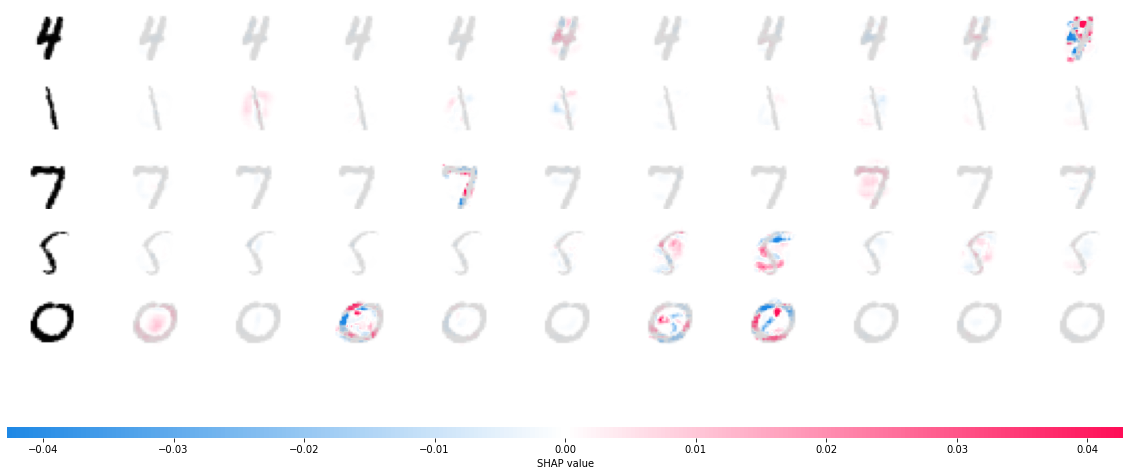

In [25]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)

# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)